In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from pycaret.time_series import TSForecastingExperiment

### Load and preprocess data

In [2]:
def loadAndPreprocessData(filePath, targetColumns):
    data = pd.read_csv(filePath)
    data = data[data['Location'] == 'Phoenix']
    data['Date_Time'] = pd.to_datetime(data['Date_Time'])
    data = data.sort_values(by='Date_Time').reset_index(drop=True)
    
    data['Date'] = data['Date_Time'].dt.date
    dailyData = data.groupby('Date').agg({
        col: 'mean' for col in targetColumns
    }).reset_index()

    dailyData['Date'] = pd.to_datetime(dailyData['Date'])
    dailyData = dailyData.set_index('Date').asfreq('D')
    dailyData = dailyData.interpolate(method='time') 
    
    return dailyData

### Splitting the data into training & testing 

In [3]:
def splitData(data, targetColumn, splitRatio=0.8):
    splitIndex = int(len(data) * splitRatio)
    trainData = data.iloc[:splitIndex][[targetColumn]].copy()
    testData = data.iloc[splitIndex:][[targetColumn]].copy()
    return trainData, testData

### Train Forecasting Models

In [4]:
def setupPycaretExperiment(trainData, targetColumn):
    exp = TSForecastingExperiment()
    exp.setup(
        data=trainData,
        target=targetColumn,
        numeric_imputation_target='mean',
        session_id=123
    )
    return exp

### Printing evaluation metrics

### Metrics Calculation

In [5]:
def calculateMetrics(actual, predicted, n, k):
    print("PREDICTED ", predicted)
    print("ACTUAL ", actual)
    r2 = r2_score(actual, predicted)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    vaf = 1 - (np.var(actual - predicted) / np.var(actual))
    return {
        'R²': r2,
        'Adjusted R²': adjusted_r2,
        'VAF': vaf
    }

def plotStyledMetricsTable(metricsDf, title):

    metricsDf = metricsDf.round(4) 
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('tight')
    ax.axis('off')

    row_colors = ['white'] * len(metricsDf)
    if 'Mean' in metricsDf['Model'].values:
        mean_index = metricsDf[metricsDf['Model'] == 'Mean'].index[0]
        row_colors[mean_index] = '#FFD700'  

    table = ax.table(
        cellText=metricsDf.values,
        colLabels=metricsDf.columns,
        loc='center',
        cellLoc='center',
        rowColours=row_colors,
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(metricsDf.columns))))
    plt.title(title, fontsize=12, pad=10)
    plt.show()


### Plotting actual vs forecasted values

In [6]:
def trainAndEvaluateModels(
    exp, 
    forecastHorizon, 
    testData, 
    label, 
    minValue, 
    maxValue, 
    lineSpace=0, 
    xlim=None, 
    ylim=None
):
    models = ['arima', 'naive', 'theta', 'grand_means', 'auto_arima']
    forecasts = {}
    metricsList = []
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(
        testData.index, 
        testData[label], 
        marker='o', 
        linestyle='-', 
        label=f'Actual {label}', 
        linewidth=2, 
        alpha=0.8
    )

    lineStyles = ['-', '--', '-.', ':']
    colors = ['blue', 'orange', 'green', 'purple', 'brown']
    
    for i, model in enumerate(models):
        print(f"Training {model}...")
        trainedModel = exp.create_model(model)
        forecast = exp.predict_model(trainedModel, fh=forecastHorizon)
        
        spacedForecast = forecast + (i * lineSpace)
        forecasts[model] = spacedForecast
        
        plt.plot(
            testData.index, 
            spacedForecast, 
            marker='o', 
            linestyle=lineStyles[i % len(lineStyles)], 
            label=f'{model.upper()} Forecast (Offset by {i * lineSpace:.2f})', 
            linewidth=1.5, 
            alpha=0.9, 
            color=colors[i % len(colors)]
        )

        metrics = calculateMetrics(
            actual=testData[label].values,
            predicted=forecast.values,
            n=len(testData),
            k=1 
            
        )
        metrics['Model'] = model.upper()
        metricsList.append(metrics)

    plt.axhline(
        y=minValue, 
        color='red', 
        linestyle='--', 
        linewidth=1.5, 
        label=f'Min {label}: {minValue:.2f}'
    )
    plt.axhline(
        y=maxValue, 
        color='green', 
        linestyle='--', 
        linewidth=1.5, 
        label=f'Max {label}: {maxValue:.2f}'
    )

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.title(f'Actual vs Forecasted {label} for All Models')
    plt.xlabel('Date')
    plt.ylabel(label)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    metricsDf = pd.DataFrame(metricsList)
    
    meanRow = metricsDf.mean(numeric_only=True).to_dict()
    meanRow['Model'] = 'Mean'
    metricsDf = metricsDf.append(meanRow, ignore_index=True)

    plotStyledMetricsTable(metricsDf, title=f'Metrics Summary for {label}')

    return forecasts, metricsDf


In [7]:
def runForecastPipeline(
    filePath, 
    targetColumn, 
    forecastHorizonRatio=0.2, 
    minValue=None, 
    maxValue=None, 
    lineSpace=0, 
    xlim=None, 
    ylim=None
):
    data = loadAndPreprocessData(filePath, targetColumns=[targetColumn])
    trainData, testData = splitData(data, targetColumn, splitRatio=1 - forecastHorizonRatio)
    forecastHorizon = list(range(1, len(testData) + 1))
    
    exp = setupPycaretExperiment(trainData, targetColumn)
    forecasts = trainAndEvaluateModels(
        exp, 
        forecastHorizon, 
        testData, 
        targetColumn, 
        minValue, 
        maxValue, 
        lineSpace=lineSpace, 
        xlim=xlim, 
        ylim=ylim
    )
    
    return forecasts


,Description,Value
0,session_id,123
1,Target,Temperature_C
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(111, 1)"
5,Transformed data shape,"(111, 1)"
6,Transformed train set shape,"(110, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


Training arima...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.3032,0.1862,0.3101,0.3101,0.0212,0.0210
1,2024-04-17,0.4196,0.2566,0.4252,0.4252,0.0299,0.0294
2,2024-04-18,0.3460,0.2113,0.3485,0.3485,0.0245,0.0242
Mean,NaT,0.3563,0.2181,0.3613,0.3613,0.0252,0.0249
SD,NaT,0.0480,0.0291,0.0478,0.0478,0.0036,0.0035


PREDICTED  [[14.21  ]
 [15.5656]
 [15.1874]
 [15.5302]
 [15.7784]
 [15.8842]
 [14.9019]
 [14.5722]
 [14.5768]
 [14.5759]
 [15.9431]
 [15.5734]
 [15.9225]
 [16.1753]
 [16.2845]
 [15.3048]
 [14.9769]
 [14.9828]
 [14.983 ]
 [16.3509]
 [15.9818]
 [16.3312]
 [16.5844]
 [16.6938]
 [15.7142]
 [15.3865]
 [15.3925]
 [15.3927]]
ACTUAL  [15.2964156  16.09999039 14.79602135 15.8108025  15.14076736 14.976879
 13.94448714 14.21934609 14.42883016 14.40370413 15.67112629 14.6767261
 14.16205148 14.76935887 15.11876859 15.86577321 14.38995653 14.63695973
 15.6002203  15.34509214 14.81782653 14.70950117 15.28569974 14.23650695
 15.61971966 13.86317368 15.62275314 14.96677823]
Training naive...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.9987,0.6133,1.0215,1.0215,0.0700,0.0676
1,2024-04-17,0.3538,0.2164,0.3586,0.3586,0.0252,0.0249
2,2024-04-18,0.0167,0.0102,0.0168,0.0168,0.0012,0.0012
Mean,NaT,0.4564,0.2800,0.4656,0.4656,0.0321,0.0312
SD,NaT,0.4074,0.2503,0.4171,0.4171,0.0285,0.0275


PREDICTED  [[14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]
 [14.2265]]
ACTUAL  [15.2964156  16.09999039 14.79602135 15.8108025  15.14076736 14.976879
 13.94448714 14.21934609 14.42883016 14.40370413 15.67112629 14.6767261
 14.16205148 14.76935887 15.11876859 15.86577321 14.38995653 14.63695973
 15.6002203  15.34509214 14.81782653 14.70950117 15.28569974 14.23650695
 15.61971966 13.86317368 15.62275314 14.96677823]
Training theta...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,1.2974,0.7968,1.3271,1.3271,0.0909,0.0869
1,2024-04-17,1.1837,0.7240,1.1998,1.1998,0.0842,0.0808
2,2024-04-18,0.7540,0.4605,0.7594,0.7594,0.0534,0.0520
Mean,NaT,1.0784,0.6604,1.0954,1.0954,0.0762,0.0733
SD,NaT,0.2340,0.1445,0.2432,0.2432,0.0163,0.0152


PREDICTED  [[14.0633]
 [14.5546]
 [14.1488]
 [13.7449]
 [14.4666]
 [13.9697]
 [14.3776]
 [14.6224]
 [14.8544]
 [14.361 ]
 [14.8619]
 [14.4469]
 [14.0338]
 [14.77  ]
 [14.262 ]
 [14.6778]
 [14.9269]
 [15.163 ]
 [14.6587]
 [15.1693]
 [14.745 ]
 [14.3227]
 [15.0734]
 [14.5543]
 [14.9779]
 [15.2314]
 [15.4717]
 [14.9564]]
ACTUAL  [15.2964156  16.09999039 14.79602135 15.8108025  15.14076736 14.976879
 13.94448714 14.21934609 14.42883016 14.40370413 15.67112629 14.6767261
 14.16205148 14.76935887 15.11876859 15.86577321 14.38995653 14.63695973
 15.6002203  15.34509214 14.81782653 14.70950117 15.28569974 14.23650695
 15.61971966 13.86317368 15.62275314 14.96677823]
Training grand_means...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,2.3639,1.4517,2.4178,2.4178,0.1656,0.1805
1,2024-04-17,2.0097,1.2292,2.0369,2.0369,0.1430,0.1540
2,2024-04-18,1.9870,1.2136,2.0014,2.0014,0.1407,0.1513
Mean,NaT,2.1202,1.2982,2.1520,2.1520,0.1498,0.1620
SD,NaT,0.1726,0.1088,0.1885,0.1885,0.0112,0.0132


PREDICTED  [[12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]
 [12.2433]]
ACTUAL  [15.2964156  16.09999039 14.79602135 15.8108025  15.14076736 14.976879
 13.94448714 14.21934609 14.42883016 14.40370413 15.67112629 14.6767261
 14.16205148 14.76935887 15.11876859 15.86577321 14.38995653 14.63695973
 15.6002203  15.34509214 14.81782653 14.70950117 15.28569974 14.23650695
 15.61971966 13.86317368 15.62275314 14.96677823]
Training auto_arima...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.7648,0.4697,0.7823,0.7823,0.0536,0.0522
1,2024-04-17,0.6543,0.4002,0.6632,0.6632,0.0466,0.0455
2,2024-04-18,0.1984,0.1212,0.1999,0.1999,0.0140,0.0140
Mean,NaT,0.5392,0.3304,0.5484,0.5484,0.0381,0.0372
SD,NaT,0.2451,0.1506,0.2512,0.2512,0.0172,0.0167


PREDICTED  [[14.3371]
 [14.5295]
 [14.4549]
 [14.5071]
 [14.5304]
 [14.5168]
 [14.3285]
 [14.2408]
 [14.2262]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]
 [14.2556]]
ACTUAL  [15.2964156  16.09999039 14.79602135 15.8108025  15.14076736 14.976879
 13.94448714 14.21934609 14.42883016 14.40370413 15.67112629 14.6767261
 14.16205148 14.76935887 15.11876859 15.86577321 14.38995653 14.63695973
 15.6002203  15.34509214 14.81782653 14.70950117 15.28569974 14.23650695
 15.61971966 13.86317368 15.62275314 14.96677823]


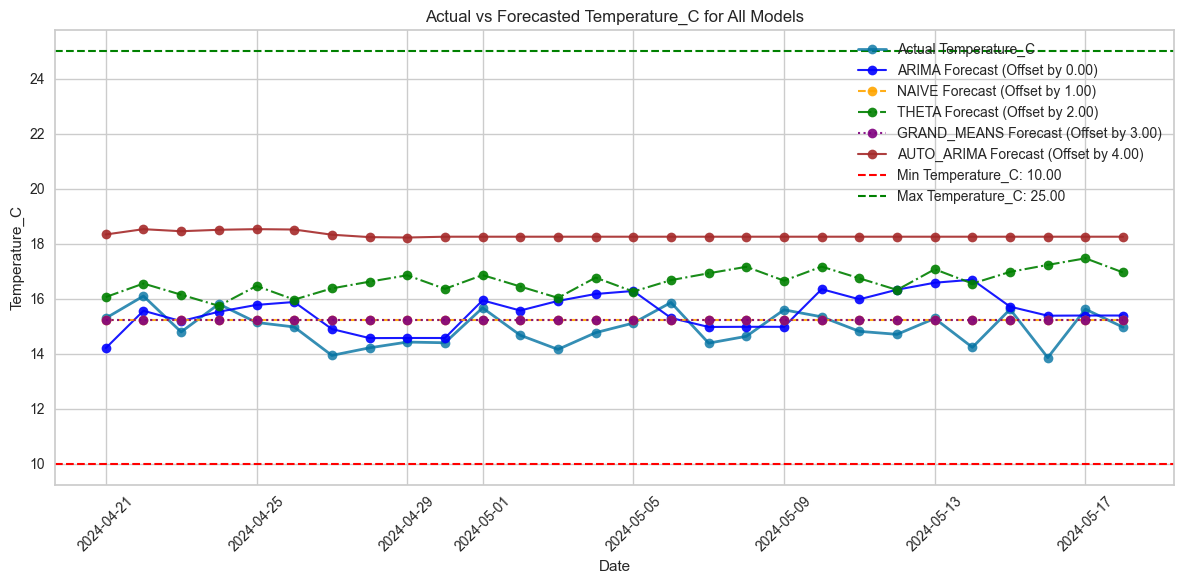

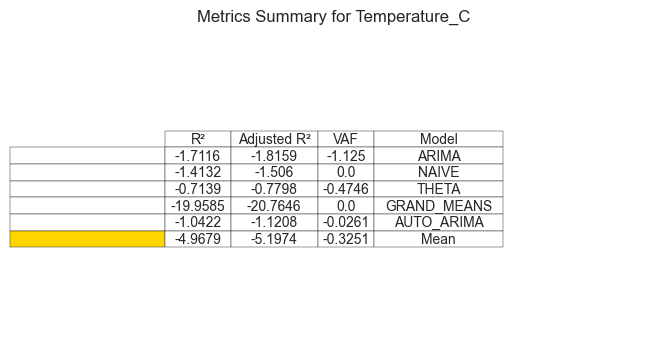

,Description,Value
0,session_id,123
1,Target,Humidity_pct
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(111, 1)"
5,Transformed data shape,"(111, 1)"
6,Transformed train set shape,"(110, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


Training arima...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,1.4947,1.1918,1.0248,1.0248,0.0169,0.0170
1,2024-04-17,0.3762,0.2997,0.2619,0.2619,0.0043,0.0043
2,2024-04-18,0.1729,0.1376,0.1198,0.1198,0.0020,0.0020
Mean,NaT,0.6813,0.5430,0.4688,0.4688,0.0077,0.0078
SD,NaT,0.5812,0.4635,0.3974,0.3974,0.0065,0.0066


PREDICTED  [[60.1199]
 [60.0799]
 [60.0703]
 [60.0681]
 [60.0675]
 [60.0674]
 [60.0674]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]]
ACTUAL  [59.11055027 60.87428421 60.14652902 60.08109546 59.9105931  60.33301414
 58.90852048 58.65473285 59.86966571 61.4902417  59.00061897 59.14630541
 60.84796506 60.30084801 59.57147597 60.25323349 59.57660662 60.17890786
 61.32769123 59.95685619 60.91010416 61.20732519 60.09995112 58.8845095
 58.70705906 60.35943334 59.60795609 59.06579377]
Training naive...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,2.6782,2.1353,1.8361,1.8361,0.0302,0.0307
1,2024-04-17,0.4326,0.3446,0.3012,0.3012,0.0050,0.0050
2,2024-04-18,0.3015,0.2399,0.2089,0.2089,0.0035,0.0035
Mean,NaT,1.1374,0.9066,0.7821,0.7821,0.0129,0.0130
SD,NaT,1.0908,0.8699,0.7463,0.7463,0.0123,0.0125


PREDICTED  [[60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]
 [60.2879]]
ACTUAL  [59.11055027 60.87428421 60.14652902 60.08109546 59.9105931  60.33301414
 58.90852048 58.65473285 59.86966571 61.4902417  59.00061897 59.14630541
 60.84796506 60.30084801 59.57147597 60.25323349 59.57660662 60.17890786
 61.32769123 59.95685619 60.91010416 61.20732519 60.09995112 58.8845095
 58.70705906 60.35943334 59.60795609 59.06579377]
Training theta...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.8438,0.6728,0.5785,0.5785,0.0095,0.0096
1,2024-04-17,0.3631,0.2892,0.2528,0.2528,0.0042,0.0042
2,2024-04-18,0.0452,0.0360,0.0313,0.0313,0.0005,0.0005
Mean,NaT,0.4174,0.3327,0.2876,0.2876,0.0047,0.0048
SD,NaT,0.3283,0.2618,0.2247,0.2247,0.0037,0.0037


PREDICTED  [[60.2612]
 [60.2629]
 [60.2647]
 [60.2664]
 [60.2681]
 [60.2699]
 [60.2716]
 [60.2734]
 [60.2751]
 [60.2769]
 [60.2786]
 [60.2803]
 [60.2821]
 [60.2838]
 [60.2856]
 [60.2873]
 [60.2891]
 [60.2908]
 [60.2926]
 [60.2943]
 [60.296 ]
 [60.2978]
 [60.2995]
 [60.3013]
 [60.303 ]
 [60.3048]
 [60.3065]
 [60.3083]]
ACTUAL  [59.11055027 60.87428421 60.14652902 60.08109546 59.9105931  60.33301414
 58.90852048 58.65473285 59.86966571 61.4902417  59.00061897 59.14630541
 60.84796506 60.30084801 59.57147597 60.25323349 59.57660662 60.17890786
 61.32769123 59.95685619 60.91010416 61.20732519 60.09995112 58.8845095
 58.70705906 60.35943334 59.60795609 59.06579377]
Training grand_means...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,1.0842,0.8644,0.7433,0.7433,0.0122,0.0123
1,2024-04-17,0.6250,0.4979,0.4352,0.4352,0.0072,0.0072
2,2024-04-18,0.3210,0.2554,0.2224,0.2224,0.0037,0.0037
Mean,NaT,0.6767,0.5392,0.4670,0.4670,0.0077,0.0077
SD,NaT,0.3137,0.2503,0.2139,0.2139,0.0035,0.0035


PREDICTED  [[60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]
 [60.0676]]
ACTUAL  [59.11055027 60.87428421 60.14652902 60.08109546 59.9105931  60.33301414
 58.90852048 58.65473285 59.86966571 61.4902417  59.00061897 59.14630541
 60.84796506 60.30084801 59.57147597 60.25323349 59.57660662 60.17890786
 61.32769123 59.95685619 60.91010416 61.20732519 60.09995112 58.8845095
 58.70705906 60.35943334 59.60795609 59.06579377]
Training auto_arima...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,1.4947,1.1918,1.0248,1.0248,0.0169,0.0170
1,2024-04-17,0.3762,0.2997,0.2619,0.2619,0.0043,0.0043
2,2024-04-18,0.1729,0.1376,0.1198,0.1198,0.0020,0.0020
Mean,NaT,0.6813,0.5430,0.4688,0.4688,0.0077,0.0078
SD,NaT,0.5812,0.4635,0.3974,0.3974,0.0065,0.0066


PREDICTED  [[60.1199]
 [60.0799]
 [60.0703]
 [60.0681]
 [60.0675]
 [60.0674]
 [60.0674]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]
 [60.0673]]
ACTUAL  [59.11055027 60.87428421 60.14652902 60.08109546 59.9105931  60.33301414
 58.90852048 58.65473285 59.86966571 61.4902417  59.00061897 59.14630541
 60.84796506 60.30084801 59.57147597 60.25323349 59.57660662 60.17890786
 61.32769123 59.95685619 60.91010416 61.20732519 60.09995112 58.8845095
 58.70705906 60.35943334 59.60795609 59.06579377]


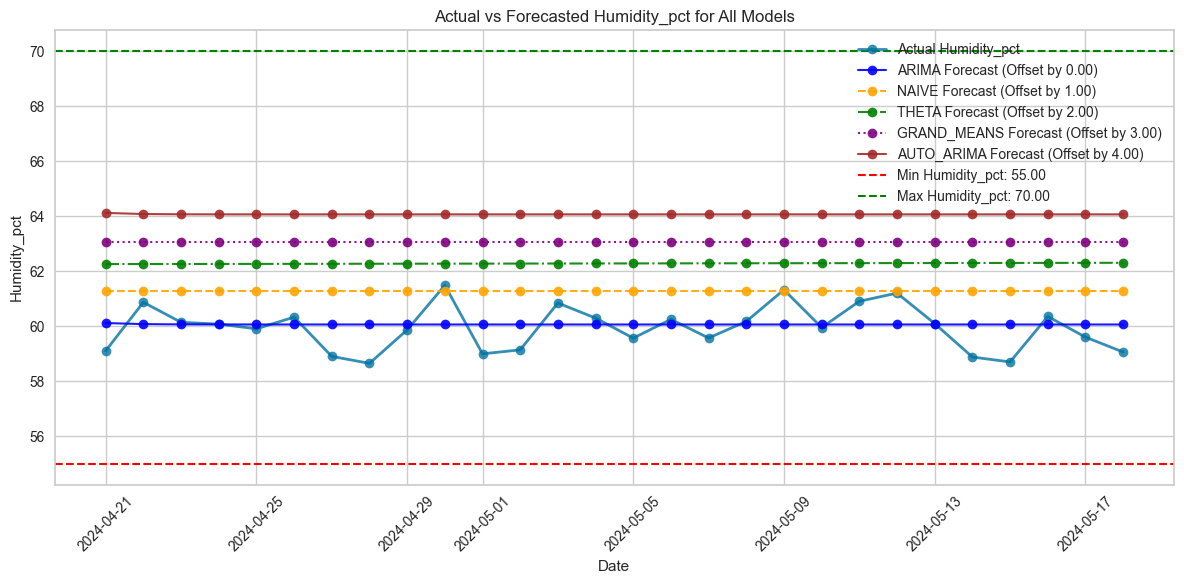

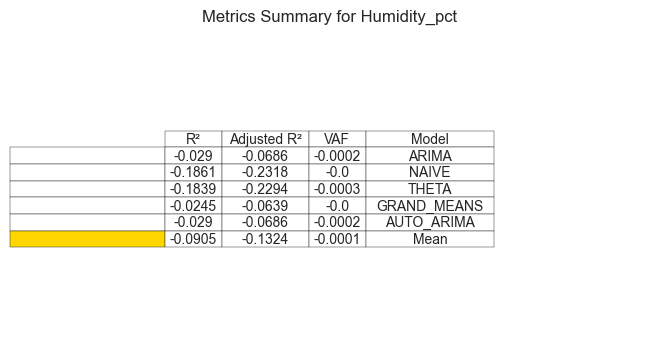

In [8]:
filePath = 'weather_data.csv'
temperatureForecasts = runForecastPipeline(
    filePath, 
    'Temperature_C', 
    minValue=10, 
    maxValue=25, 
    lineSpace=1, 
)

humidityForecasts = runForecastPipeline(
    filePath, 
    'Humidity_pct', 
    minValue=55, 
    maxValue=70, 
    lineSpace=1
)
